
Parameters of Largest Circle:
Radius: 72.40773439350254
Center Coordinates as (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



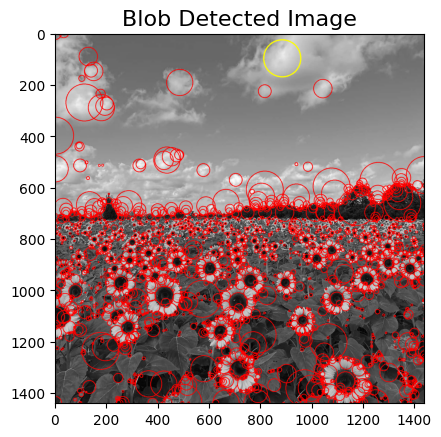

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function to generate LoG kernel
def generate_log_kernel(sigma, size):
    if size % 2 == 0:
        size = size + 1

    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)

    if k_sum != 0:
        kernel /= np.sum(kernel)

    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel

# Function to display the kernel
def display_kernel(kernel):
    plt.imshow(kernel, cmap='viridis')
    plt.colorbar()
    plt.title('Kernel')
    plt.show()

# Load the input image
image = cv.imread(r"/content/drive/MyDrive/Assignment2_fitting & Allignment/images/the_berry_farms_sunflower_field.jpeg")

# Convert image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)
cv.normalize(gray_image, gray_image, 1, 0, cv.NORM_MINMAX)

# Parameters for LoG filtering
initial_sigma = 0.4
scale_factor = np.sqrt(2)
num_scales = 15
sigmas = initial_sigma * np.power(scale_factor, np.arange(num_scales))

# LoG Filtering at Multiple Scales
image_stack = None
for i in range(num_scales):
    size = int(2 * np.ceil(4 * sigmas[i]) + 1)
    kernel = generate_log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
    filtered_image = cv.filter2D(gray_image, cv.CV_32F, kernel)
    filtered_image = pow(filtered_image, 2)
    if i == 0:
        image_stack = filtered_image
    else:
        image_stack = np.dstack((image_stack, filtered_image))

# Maximum Response Extraction
scale_space = None
for i in range(num_scales):
    dilated_image = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
    if i == 0:
        scale_space = dilated_image
    else:
        scale_space = np.dstack((scale_space, dilated_image))

max_response_stack = np.amax(scale_space, axis=2)
max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_scales, axis=2)
max_response_stack = np.multiply((max_response_stack == scale_space), scale_space)

# Extract blob parameters
radius_vector = None
x_coordinate_vector = None
y_coordinate_vector = None
for i in range(num_scales):
    radius = np.sqrt(2) * sigmas[i]
    threshold = 0.01
    valid_responses = (max_response_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
    valid_responses[valid_responses <= threshold] = 0
    (x, y) = np.nonzero(valid_responses)
    if i == 1:
        x_coordinate_vector = x
        y_coordinate_vector = y
        radius_vector = np.repeat(radius, np.size(x))
    else:
        x_coordinate_vector = np.concatenate((x_coordinate_vector, x), axis=None)
        y_coordinate_vector = np.concatenate((y_coordinate_vector, y), axis=None)
        tmp_radius_vector = np.repeat(radius, np.size(x))
        radius_vector = np.concatenate((radius_vector, tmp_radius_vector), axis=None)

# Find the parameters of the largest circles
max_radius = np.max(radius_vector)
max_circle_index = np.argmax(radius_vector)
max_x_coordinate = x_coordinate_vector[max_circle_index]
max_y_coordinate = y_coordinate_vector[max_circle_index]

# Report the parameters of the largest circles
print()
print(f"Parameters of Largest Circle:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates as (x, y): ({max_x_coordinate}, {max_y_coordinate})")
min_sigma_value = np.min(sigmas)
max_sigma_value = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma_value}")
print(f"Maximum σ: {max_sigma_value}")
print()

# Highlight the detected circles in the output image
output_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
output_image = cv.cvtColor(output_image, cv.COLOR_GRAY2BGR)

for i in range(np.size(x_coordinate_vector)):
    if i == max_circle_index:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0,255,255), 3) # Largest circle in yellow
    else:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0, 0, 255), 2) # Other circles in red

# Save the output image
cv.imwrite("../Outputs/" + "the_berry_farms_sunflower_field" + "_blob_detected_COLOUR.jpeg", output_image)

# Display the output image
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image", fontsize=16)
plt.show()


Parameters of Largest Circle:
Radius: 18.10193359837563
Center Coordinates (x, y): (165, 337)
Range of σ values: Minimum σ = 0.4, Maximum σ = 51.200000000000045


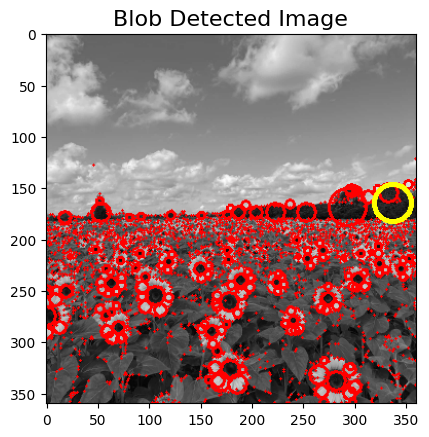

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to generate LoG kernel
def generate_log_kernel(sigma, size):
    # Ensure kernel size is odd
    if size % 2 == 0:
        size += 1

    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)

    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)

    if k_sum != 0:
        kernel /= np.sum(kernel)

    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)

    return kernel

# Load image and convert to grayscale
image = cv.imread('/content/drive/MyDrive/Assignment2_fitting & Allignment/images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4) # Modified: Corrected file path
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)
cv.normalize(gray_image, gray_image, 1, 0, cv.NORM_MINMAX)

# Parameters for LoG filtering
initial_sigma = 0.4  # starting value of sigma
scale_factor = np.sqrt(2)  # factor to increase sigma at each scale
num_scales = 15  # number of scales
sigmas = initial_sigma * np.power(scale_factor, np.arange(num_scales))

# Perform LoG Filtering at multiple scales
image_stack = None
for i in range(num_scales):
    size = int(2 * np.ceil(4 * sigmas[i]) + 1)
    kernel = generate_log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
    filtered_image = cv.filter2D(gray_image, cv.CV_32F, kernel)
    filtered_image = np.square(filtered_image)

    if i == 0:
        image_stack = filtered_image
    else:
        image_stack = np.dstack((image_stack, filtered_image))

# Detect maxima over scale-space
scale_space = None
for i in range(num_scales):
    dilated_image = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F)
    if i == 0:
        scale_space = dilated_image
    else:
        scale_space = np.dstack((scale_space, dilated_image))

max_response_stack = np.amax(scale_space, axis=2)
max_response_stack = np.repeat(max_response_stack[:, :, np.newaxis], num_scales, axis=2)
max_response_stack = np.multiply((max_response_stack == scale_space), scale_space)

# Extract blob parameters
radius_vector = []
x_coordinate_vector = []
y_coordinate_vector = []

for i in range(num_scales):
    radius = np.sqrt(2) * sigmas[i]
    threshold = 0.04
    valid_responses = (max_response_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
    valid_responses[valid_responses <= threshold] = 0
    (x, y) = np.nonzero(valid_responses)

    x_coordinate_vector.extend(x)
    y_coordinate_vector.extend(y)
    radius_vector.extend(np.repeat(radius, len(x)))

# Find the parameters of the largest circles
max_radius = np.max(radius_vector)
max_circle_index = np.argmax(radius_vector)
max_x_coordinate = x_coordinate_vector[max_circle_index]
max_y_coordinate = y_coordinate_vector[max_circle_index]

# Report the parameters of the largest circle
print(f"Parameters of Largest Circle:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x_coordinate}, {max_y_coordinate})")
print(f"Range of σ values: Minimum σ = {np.min(sigmas)}, Maximum σ = {np.max(sigmas)}")

# Highlight the detected circles in the output image
output_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
output_image = cv.cvtColor(output_image, cv.COLOR_GRAY2BGR)

for i in range(len(x_coordinate_vector)):
    if i == max_circle_index:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0,255,255), 3)  # Largest circle in yellow
    else:
        cv.circle(output_image, (y_coordinate_vector[i], x_coordinate_vector[i]), int(radius_vector[i]), (0, 0, 255), 2)  # Other circles in red

# Save the output image
cv.imwrite("the_berry_farms_sunflower_field_blob_detected_COLOUR.jpeg", output_image)

# Display the output image
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image", fontsize=16)
plt.show()
